# Linear Regression with Statsmodels for Movie Revenue - Part 2

- xx/xx/xx

## Activity: Create a Linear Regression Model with Statsmodels for Revenue

- Last Class:
    - We started working with JUST the data data from the TMDB API for years 2000-2021. 
    - We prepared the data for modeling
        - Some feature engineering
        - Our usual Preprocessing
        - New steps for statsmodels!
    - We fit a statsmodels linear regression.
    
    
- Today:
    - We Will inspect the model summary.
    - We will create the visualizations to check assumptions about the residuals.
    - We will iterate upon our model until we meet the 4 assumptions as best we can.
    - We will discuss tactics for dealing with violations of the assumptions. 
    - We will use our coefficients to make stakeholder recommendations (if theres time 🤞).

> **[🕹 Click here to jump to Part 2!](#🕹-Part-2:-Checking-Model-Assumptions)**

# 📺 Previously, on...

## Loading the Data

In [52]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm

In [53]:
pd.set_option('display.max_columns',100)

### 📚 Finding & Loading Batches of Files with `glob`

In [54]:
## Checking what data we already in our Data folder using os.listdir
import os
FOLDER = 'Data/'
file_list = sorted(os.listdir(FOLDER))
# file_list

In [55]:
## Try loading in the first .csv.gz file from the list
#pd.read_csv(file_list[1])

> Why isn't it working?

In [56]:
## let's check the filepath 
file_list[1]

'2010-2021'

In [57]:
## add the folder plus filename
FOLDER+ file_list[1]

'Data/2010-2021'

In [58]:
## try read csv with folder plus filename
#pd.read_csv(FOLDER+ file_list[1])

- Now we would do that in a loop, and only want to open .csv.gz.
- But there is a better way!
>- Introducing `glob`
    - Glob takes a filepath/query and will find every filename that matches the pattern provided.
    - We use asterisks as wildcards in our query.
    


In [59]:
import glob
## Make a filepath query
q = FOLDER+"*.csv.gz"
print(q)

Data/*.csv.gz


In [60]:
# Use glob.glob to get COMPLETE filepaths
file_list = glob.glob(q)
file_list

['Data/final_tmdb_data_2006.csv.gz',
 'Data/title_basics_cleaned.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/title_ratings_cleaned.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/combined_tmdb_data.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/combined_all_data.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/title_akas_cleaned.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz']

In [61]:
# Use glob.glob to get COMPLETE filepaths
q = FOLDER+"final_*.csv.gz"
print(q)
file_list = sorted(glob.glob(q))
# file_list

Data/final_*.csv.gz


> But where are the rest of the years?

In [62]:
## in a sub-folder
# os.listdir(FOLDER+'2010-2021')

- Recursive Searching with glob.
    - add a `**/` in the middle of your query to grab any matches from all subfolders. 

In [63]:
# Use glob.glob to get COMPLETE filepaths
q = FOLDER+"/**/final_*.csv.gz"
print(q)
file_list = sorted(glob.glob(q,recursive=True))
file_list

Data//**/final_*.csv.gz


['Data/2010-2021/final_tmdb_data_2010.csv.gz',
 'Data/2010-2021/final_tmdb_data_2011.csv.gz',
 'Data/2010-2021/final_tmdb_data_2012.csv.gz',
 'Data/2010-2021/final_tmdb_data_2013.csv.gz',
 'Data/2010-2021/final_tmdb_data_2014.csv.gz',
 'Data/2010-2021/final_tmdb_data_2015.csv.gz',
 'Data/2010-2021/final_tmdb_data_2016.csv.gz',
 'Data/2010-2021/final_tmdb_data_2017.csv.gz',
 'Data/2010-2021/final_tmdb_data_2018.csv.gz',
 'Data/2010-2021/final_tmdb_data_2019.csv.gz',
 'Data/2010-2021/final_tmdb_data_2020.csv.gz',
 'Data/2010-2021/final_tmdb_data_2021.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz']

In [64]:
# ## use a list comprehension to load in all files into 1 dataframe
# df = pd.concat([pd.read_csv(f) for f in file_list])
# df

- Dealing with ParserErrors with "possibly malformed files"

    - for a reason I do not fully understand yet, some of the files I downloaded error if I try to read them.
        - "ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.`
    - After some googling, the fix was to add `lineterminator='\n'` to pd.read_csv


In [65]:
## use a list comprehension to load in all files into 1 dataframe
df = pd.concat([pd.read_csv(f,lineterminator='\n') for f in file_list])
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
2351,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
2352,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
2353,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


In [66]:
# remove ids that are 0
df = df.loc[ df['imdb_id']!='0']
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
2351,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
2352,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
2353,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


In [67]:
df = df.reset_index(drop=True)
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
1,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
2,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
3,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
4,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60126,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
60127,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60128,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


In [68]:
## saving the combined csv to disk
df.to_csv(FOLDER+'combined_tmdb_data.csv.gz',compression='gzip',index=False)

df = pd.read_csv(FOLDER+'combined_tmdb_data.csv.gz',lineterminator='\n')
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
1,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
2,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
3,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
4,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60126,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
60127,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60128,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


## Preprocessing

In [69]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', 'status',
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN
1,tt0326965,0.0,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13
2,tt0331312,0.0,NaN,0.0,[],0.600,[],2010-01-01,0.0,0.0,This Wretched Life,5.0,1.0,NaN
3,tt0393049,0.0,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",2010-05-20,0.0,98.0,Anderson's Cross,4.0,5.0,NaN
4,tt0398286,0.0,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2010-11-24,592461732.0,100.0,Tangled,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",2009-09-01,250000.0,77.0,Cold by Nature,0.0,0.0,PG-13
60126,tt7786614,0.0,NaN,0.0,[],0.600,[],2009-01-01,0.0,100.0,Tattoo,5.0,1.0,NaN
60127,tt8170758,0.0,NaN,0.0,[],0.600,[],2009-10-27,0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR
60128,tt9330112,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN


### Feature Engineering


- Collection: convert to boolean
- Genres: get just name and OHE
- Cleaning Certification
- Converting release date to year, month, and day.

#### belongs to collection

In [70]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

3738

In [71]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    56392
True      3738
Name: belongs_to_collection, dtype: int64

#### genre

In [72]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [73]:
## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')
df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,genres_list
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Family
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Animation
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Science Fiction
1,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,Thriller
1,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,Mystery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,Drama
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,Thriller
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,Mystery
60129,tt9556198,0.0,True,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 14, 'nam...",0.840,"[{'id': 64599, 'logo_path': None, 'name': 'SRS...",2009-08-15,0.0,80.0,Deep Sea Monster Raiga,7.7,3.0,NaN,Action


In [74]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    

## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
0,tt0312305,0.0,False,0.0,2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0326965,0.0,False,0.0,6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0331312,0.0,False,0.0,0.600,[],2010-01-01,0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",2010-05-20,0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2010-11-24,592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",2009-09-01,250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60126,tt7786614,0.0,False,0.0,0.600,[],2009-01-01,0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60127,tt8170758,0.0,False,0.0,0.600,[],2009-10-27,0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60128,tt9330112,0.0,False,0.0,1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False


#### certification

In [75]:
## Checking Certification values
# df['certification'].value_counts(dropna=False)

# fix extra space certs
df['certification'] = df['certification'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

NaN      45507
R         6098
NR        3270
PG-13     3225
PG        1432
G          442
NC-17      156
Name: certification, dtype: int64

#### Converting year to sep features

In [76]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)
## drop original feature
df = df.drop(columns=['release_date'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,tt9330112,0.0,False,0.0,1.201,[],0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60130 non-null  object 
 1   adult                  60130 non-null  float64
 2   belongs_to_collection  60130 non-null  bool   
 3   budget                 60130 non-null  float64
 4   popularity             60130 non-null  float64
 5   production_companies   60130 non-null  object 
 6   revenue                60130 non-null  float64
 7   runtime                59298 non-null  float64
 8   title                  60130 non-null  object 
 9   vote_average           60130 non-null  float64
 10  vote_count             60130 non-null  float64
 11  certification          14623 non-null  object 
 12  Genre_Family           60130 non-null  bool   
 13  Genre_Animation        60130 non-null  bool   
 14  Genre_Science Fiction  60130 non-null  bool   
 15  Ge

In [78]:
# df= df.drop(columns='Genre_nan')

## Train Test Split

In [79]:
drop_for_model = ['title','imdb_id','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,0.0,False,0.0,2.769,0.0,45.0,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,0.0,False,0.0,6.120,0.0,90.0,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,0.0,False,0.0,0.600,0.0,0.0,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,0.0,False,300000.0,2.418,0.0,98.0,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,0.0,False,260000000.0,119.168,592461732.0,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,0.0,False,0.0,0.600,250000.0,77.0,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,0.0,False,0.0,0.600,0.0,100.0,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,0.0,False,0.0,0.600,0.0,61.0,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,0.0,False,0.0,1.201,0.0,145.0,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


In [80]:
## Make x and y variables
y = df['revenue'].copy()
X = df.drop(columns=['revenue']).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
X_train.head()

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
9538,0.0,False,0.0,1.113,80.0,5.3,5.0,NaN,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,2013.0,10.0,1.0
16553,0.0,False,0.0,1.875,92.0,6.0,2.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2015.0,4.0,15.0
34106,0.0,False,0.0,1.499,101.0,2.0,1.0,R,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2020.0,11.0,4.0
3804,0.0,False,0.0,1.506,100.0,7.7,3.0,PG,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,2011.0,9.0,24.0
37747,0.0,False,300000.0,0.600,138.0,5.0,2.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2020.0,9.0,18.0


In [81]:
X_train.isna().sum()

adult                        0
belongs_to_collection        0
budget                       0
popularity                   0
runtime                    638
vote_average                 0
vote_count                   0
certification            34082
Genre_Family                 0
Genre_Animation              0
Genre_Science Fiction        0
Genre_Thriller               0
Genre_Mystery                0
Genre_Drama                  0
Genre_Romance                0
Genre_Comedy                 0
Genre_War                    0
Genre_Crime                  0
Genre_Action                 0
Genre_Adventure              0
Genre_Horror                 0
Genre_Fantasy                0
Genre_History                0
Genre_Western                0
Genre_Music                  0
Genre_Documentary            0
Genre_TV Movie               0
year                       792
month                      792
day                        792
dtype: int64

In [82]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification']

In [83]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['adult',
 'budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day']

In [84]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

['belongs_to_collection',
 'Genre_Family',
 'Genre_Animation',
 'Genre_Science Fiction',
 'Genre_Thriller',
 'Genre_Mystery',
 'Genre_Drama',
 'Genre_Romance',
 'Genre_Comedy',
 'Genre_War',
 'Genre_Crime',
 'Genre_Action',
 'Genre_Adventure',
 'Genre_Horror',
 'Genre_Fantasy',
 'Genre_History',
 'Genre_Western',
 'Genre_Music',
 'Genre_Documentary',
 'Genre_TV Movie']

In [85]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [86]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((num_pipe, num_cols),
                                       (cat_pipe,cat_cols),remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count', 'year', 'month',
                                  'day']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification'])])

In [87]:
## fit the col transformer
preprocessor.fit(X_train)

## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-2']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [88]:
## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


## Create the empty list
final_features = [*num_cols,*cat_features,*already_ohe_cols]
len(final_features)

36

In [89]:
preprocessor.transform(X_train).shape

(45097, 36)

In [90]:
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_tf.head()


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
9538,0.0,0.0,1.113,80.0,5.3,5.0,2013.0,10.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16553,0.0,0.0,1.875,92.0,6.0,2.0,2015.0,4.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34106,0.0,0.0,1.499,101.0,2.0,1.0,2020.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3804,0.0,0.0,1.506,100.0,7.7,3.0,2011.0,9.0,24.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37747,0.0,300000.0,0.600,138.0,5.0,2.0,2020.0,9.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                         columns=final_features, index=X_test.index)
X_test_tf.head()

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
19252,0.0,1000.0,1.422,70.0,0.0,0.0,2015.0,12.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40663,0.0,0.0,3.180,99.0,7.0,4.0,2021.0,11.0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35595,0.0,0.0,3.285,0.0,6.4,16.0,2019.0,8.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
979,0.0,0.0,1.052,90.0,5.0,4.0,2010.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44055,0.0,26000000.0,16.946,126.0,7.4,1011.0,2021.0,2.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Adding a Constant for Statsmodels

In [92]:
##import statsmodels correctly
import statsmodels.api as sm

> Tip: make sure that add_constant actually added a new column! You may need to change the parameter `has_constant` to "add"

    -- By default, statsmodels fits a line passing through the origin, i.e. it does not fit intercept. Hence, you need to use 'add_constant' so that it also fits an intercept

In [93]:
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
display(X_train_df.head(2),X_test_df.head(2))

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,const
9538,0.0,0.0,1.113,80.0,5.3,5.0,2013.0,10.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16553,0.0,0.0,1.875,92.0,6.0,2.0,2015.0,4.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,const
19252,0.0,1000.0,1.422,70.0,0.0,0.0,2015.0,12.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40663,0.0,0.0,3.180,99.0,7.0,4.0,2021.0,11.0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 🕹 Part 2: Checking Model Assumptions

## Modeling

### Statsmodels OLS

In [94]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3972.
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:46:07   Log-Likelihood:            -8.4213e+05
No. Observations:               45097   AIC:                         1.684e+06
Df Residuals:                   45061   BIC:                         1.685e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
adult                  1.371e+06   3.64e+06      0.376      0.707   -5.77e+06    8.51e+06
budget                    1.5448      0.014    110.732      0.000       1.517       1.572
popularity             1.419e+05   4441.421     31.954      0.000    1.33e+05    1.51e+05
runtime               -6249.4768   5192.945     -1.203      0.229   -1.64e+04    3928.782
vote_average          -4.954e+05   6.07e+04     -8.155      0.000   -6.14e+05   -3.76e+05
vote_count             2.895e+04    198.629    145.762      0.000    2.86e+04    2.93e+04
year                    2.57e+04   2.64e+04      0.972      0.331   -2.61e+04    7.75e+04
month                 -8.267e+04    4.2e+04     -1.968      0.049   -1.65e+05    -335.885
day                   -1.436e+04   1.62e+04     -0.886      0.376   -4.61e+04    1.74e+04
certification_G       -5.295e+06   6.82e+06     -0.776      0.438   -1.87e+07    8.08e+06
certification_MISSING -2.089e+06    6.7e+06     -0.312      0.755   -1.52e+07     1.1e+07
certification_NC-17   -6.958e+06   7.13e+06     -0.976      0.329   -2.09e+07    7.01e+06
certification_NR       -3.31e+06   6.72e+06     -0.492      0.622   -1.65e+07    9.87e+06
certification_PG      -1.681e+06    6.7e+06     -0.251      0.802   -1.48e+07    1.15e+07
certification_PG-13   -1.082e+07   6.67e+06     -1.623      0.105   -2.39e+07    2.25e+06
certification_R       -1.659e+07   6.64e+06     -2.500      0.012   -2.96e+07   -3.58e+06
belongs_to_collection  1.158e+07   6.56e+05     17.642      0.000    1.03e+07    1.29e+07
Genre_Family           -1.38e+06   7.42e+05     -1.859      0.063   -2.83e+06    7.49e+04
Genre_Animation        4.821e+05    9.2e+05      0.524      0.600   -1.32e+06    2.29e+06
Genre_Science Fiction -5.211e+06   6.74e+05     -7.730      0.000   -6.53e+06   -3.89e+06
Genre_Thriller        -1.327e+06   4.29e+05     -3.095      0.002   -2.17e+06   -4.86e+05
Genre_Mystery         -2.097e+06   6.88e+05     -3.046      0.002   -3.45e+06   -7.48e+05
Genre_Drama           -3.558e+05   3.37e+05     -1.054      0.292   -1.02e+06    3.06e+05
Genre_Romance           2.86e+04   4.59e+05      0.062      0.950   -8.72e+05    9.29e+05
Genre_Comedy          -3.946e+05   3.62e+05     -1.091      0.275    -1.1e+06    3.14e+05
Genre_War             -1.922e+06   1.23e+06     -1.559      0.119   -4.34e+06    4.95e+05
Genre_Crime           -2.812e+06   5.87e+05     -4.792      0.000   -3.96e+06   -1.66e+06
Genre_Action          -1.452e+06   5.04e+05     -2.880      0.004   -2.44e+06   -4.64e+05
Genre_Adventure        2.352e+06   7.41e+05      3.174      0.002       9e+05    3.81e+06
Genre_Horror          -5.668e+04   4.57e+05     -0.124      0.901   -9.53e+05     8.4e+05
Genre_Fantasy         -1.223e+06   7.42e+05     -1.648      0.099   -2.68e+06    2.31e+05
Genre_History         -

In [95]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.755
Testing R^2: 0.756


# The Assumptions of Linear Regression

- The 4 Assumptions of a Linear Regression are:
    - Linearity: That the input features have a linear relationship with the target.
    - Independence of features (AKA Little-to-No Multicollinearity): That the features are not strongly related to other features.
    - **Normality: The model's residuals are approximately normally distributed.**
    - **Homoscedasticity: The model residuals have equal variance across all predictions.**


### QQ-Plot for Checking for Normality

<AxesSubplot:ylabel='Count'>

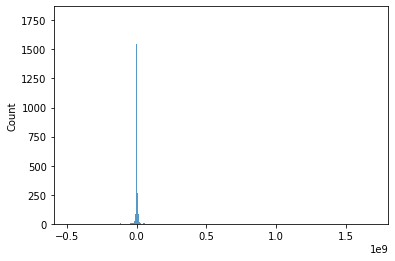

In [96]:
## Create a Q-QPlot
resids = y_train - y_hat_train
sns.histplot(resids)



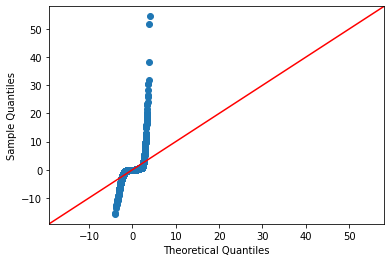

In [97]:
# first calculate residuals 
## then use sm's qqplot with line='45' fit=True
sm.graphics.qqplot(resids, fit=True, line='45');


### Residual Plot for Checking Homoscedasticity

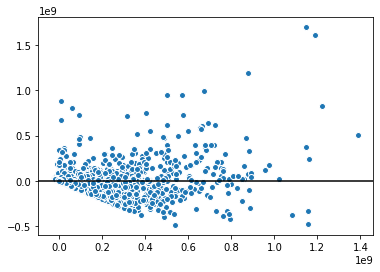

In [98]:
## Plot scatterplot with y_hat_test vs resids
plt.scatter(y_hat_train, resids, ec='white')
plt.axhline(0,color='k');

### Putting it all together into a function

In [99]:
def evaluate_ols(result,X_train_df, y_train, show_summary=True):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    try:
        display(result.summary())
    except:
        pass
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3972.
Date:                Wed, 10 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:46:11   Log-Likelihood:            -8.4213e+05
No. Observations:               45097   AIC:                         1.684e+06
Df Residuals:                   45061   BIC:                         1.685e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
adult                  1.371e+06   3.64e+06      0.376      0.707   -5.77e+06    8.51e+06
budget                    1.5448      0.014    110.732      0.000       1.517       1.572
popularity             1.419e+05   4441.421     31.954      0.000    1.33e+05    1.51e+05
runtime               -6249.4768   5192.945     -1.203      0.229   -1.64e+04    3928.782
vote_average          -4.954e+05   6.07e+04     -8.155      0.000   -6.14e+05   -3.76e+05
vote_count             2.895e+04    198.629    145.762      0.000    2.86e+04    2.93e+04
year                    2.57e+04   2.64e+04      0.972      0.331   -2.61e+04    7.75e+04
month                 -8.267e+04    4.2e+04     -1.968      0.049   -1.65e+05    -335.885
day                   -1.436e+04   1.62e+04     -0.886      0.376   -4.61e+04    1.74e+04
certification_G       -5.295e+06   6.82e+06     -0.776      0.438   -1.87e+07    8.08e+06
certification_MISSING -2.089e+06    6.7e+06     -0.312      0.755   -1.52e+07     1.1e+07
certification_NC-17   -6.958e+06   7.13e+06     -0.976      0.329   -2.09e+07    7.01e+06
certification_NR       -3.31e+06   6.72e+06     -0.492      0.622   -1.65e+07    9.87e+06
certification_PG      -1.681e+06    6.7e+06     -0.251      0.802   -1.48e+07    1.15e+07
certification_PG-13   -1.082e+07   6.67e+06     -1.623      0.105   -2.39e+07    2.25e+06
certification_R       -1.659e+07   6.64e+06     -2.500      0.012   -2.96e+07   -3.58e+06
belongs_to_collection  1.158e+07   6.56e+05     17.642      0.000    1.03e+07    1.29e+07
Genre_Family           -1.38e+06   7.42e+05     -1.859      0.063   -2.83e+06    7.49e+04
Genre_Animation        4.821e+05    9.2e+05      0.524      0.600   -1.32e+06    2.29e+06
Genre_Science Fiction -5.211e+06   6.74e+05     -7.730      0.000   -6.53e+06   -3.89e+06
Genre_Thriller        -1.327e+06   4.29e+05     -3.095      0.002   -2.17e+06   -4.86e+05
Genre_Mystery         -2.097e+06   6.88e+05     -3.046      0.002   -3.45e+06   -7.48e+05
Genre_Drama           -3.558e+05   3.37e+05     -1.054      0.292   -1.02e+06    3.06e+05
Genre_Romance           2.86e+04   4.59e+05      0.062      0.950   -8.72e+05    9.29e+05
Genre_Comedy          -3.946e+05   3.62e+05     -1.091      0.275    -1.1e+06    3.14e+05
Genre_War             -1.922e+06   1.23e+06     -1.559      0.119   -4.34e+06    4.95e+05
Genre_Crime           -2.812e+06   5.87e+05     -4.792      0.000   -3.96e+06   -1.66e+06
Genre_Action          -1.452e+06   5.04e+05     -2.880      0.004   -2.44e+06   -4.64e+05
Genre_Adventure        2.352e+06   7.41e+05      3.174      0.002       9e+05    3.81e+06
Genre_Horror          -5.668e+04   4.57e+05     -0.124      0.901   -9.53e+05     8.4e+05
Genre_Fantasy         -1.223e+06   7.42e+05     -1.648      0.099   -2.68e+06    2.31e+05
Genre_History         -

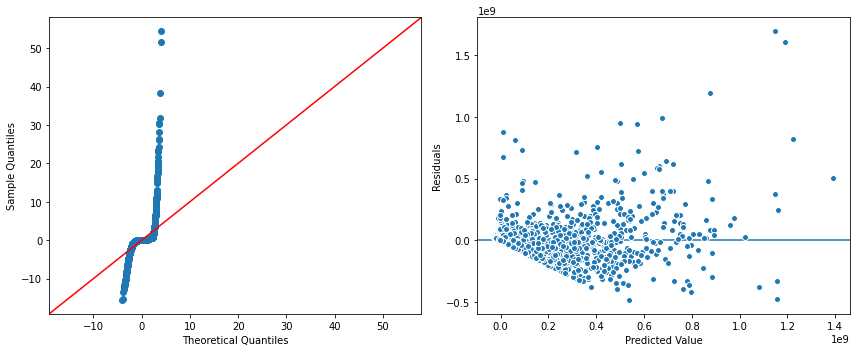

In [100]:
evaluate_ols(result,X_train_df, y_train)

# Improving Our Model:

> "Garbage In = Garbage Out"


- Before we dive into iterating on our model, I realized there were some big issues that I did not account for in the original data. 
    - some movies may not have been released. 
    - We should probably remove movies with 0 budget and revenue.
    

In [101]:
## reload the data
df = pd.read_csv(FOLDER+'combined_tmdb_data.csv.gz',lineterminator='\n')
df.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
1,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13


### Repeating Feature Engineering

In [102]:
## Columns to exclude - Keeping Status and companies
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', #'status','production_companies'
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)

## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()

## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')

## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    


## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])


#### Fixing Certification
## Checking Certification values
df['certification'].value_counts(dropna=False)
# fix extra space certs
df['certification'] = df['certification'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)


#### Converting year to sep features
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

## drop original feature
df = df.drop(columns=['release_date'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Released,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,Released,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,Released,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Released,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Released,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Released,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Released,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,Released,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,tt9330112,0.0,False,0.0,1.201,[],0.0,145.0,Released,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


### New Filtering

- Make sure to only keep:
    1. Status=Released.
    2. Budget >0
    3. Revenue >0

In [103]:
## Check status
df['status'].value_counts()

Released           60097
Post Production       27
In Production          6
Name: status, dtype: int64

In [104]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,tt9330112,0.0,False,0.0,1.201,[],0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


In [105]:
## filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",5.924617e+08,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
6,tt0411951,0.0,True,30000000.0,70.694,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...",9.670000e+05,92.0,Tekken,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
9,tt0427152,0.0,False,69000000.0,21.747,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...",8.638786e+07,114.0,Dinner for Schmucks,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
10,tt0429493,0.0,False,110000000.0,56.494,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...",1.772388e+08,117.0,The A-Team,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
11,tt0435761,0.0,True,200000000.0,93.983,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...",1.066970e+09,103.0,Toy Story 3,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59859,tt1532382,0.0,True,3500000.0,4.838,[],3.704408e+06,97.0,Hooked on the Game,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
59887,tt1542960,0.0,False,300000.0,1.937,"[{'id': 46722, 'logo_path': None, 'name': 'Gol...",2.000000e+05,122.0,The Figurine (Araromire),4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
59923,tt1560950,0.0,True,600.0,1.795,[],3.000000e+00,81.0,D@bbe 2,1.9,10.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,12.0,24.0
59929,tt1565058,0.0,True,125000.0,5.989,"[{'id': 4580, 'logo_path': None, 'name': 'Cine...",3.470000e+06,88.0,A Blood Pledge,5.4,40.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,6.0,18.0


### Production Company

In [106]:
df['production_companies']

4        [{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...
6        [{'id': 5882, 'logo_path': None, 'name': 'Namc...
9        [{'id': 2242, 'logo_path': None, 'name': 'Ever...
10       [{'id': 10908, 'logo_path': None, 'name': 'Pho...
11       [{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...
                               ...                        
59859                                                   []
59887    [{'id': 46722, 'logo_path': None, 'name': 'Gol...
59923                                                   []
59929    [{'id': 4580, 'logo_path': None, 'name': 'Cine...
59937    [{'id': 1038, 'logo_path': '/o62j8ZNXmRTrq6Thv...
Name: production_companies, Length: 5090, dtype: object

In [107]:
## getting longest string to check for multiple companies
idxmax = df['production_companies'].apply(len).idxmax()
idxmax 

44234

In [108]:
test = df.loc[idxmax, 'production_companies']
test

"[{'id': 53671, 'logo_path': None, 'name': 'Lantia Cinema & Audiovisivi', 'origin_country': ''}, {'id': 8, 'logo_path': '/78ilmDNTpdCfsakrsLqmAUkFTrO.png', 'name': 'Fine Line Features', 'origin_country': ''}, {'id': 76, 'logo_path': '/nebkQYtQKhZyHJfh5v0oGpNbPzu.png', 'name': 'Zentropa Entertainments', 'origin_country': 'DK'}, {'id': 119, 'logo_path': '/1di2gITGUZr730AMuMKiCrP90Vl.png', 'name': 'DR', 'origin_country': 'DK'}, {'id': 157, 'logo_path': None, 'name': 'SVT Drama', 'origin_country': ''}, {'id': 201, 'logo_path': '/6UIpEURdjnmcJPwgTDRzVRuwADr.png', 'name': 'ARTE', 'origin_country': 'FR'}, {'id': 321, 'logo_path': '/pfp6VWF3tYfOHHVRHpYe2iGcYrf.png', 'name': 'Memfis Film', 'origin_country': 'SE'}, {'id': 591, 'logo_path': '/q5I5RDwMEiqoNmfaJgd2LraEOJY.png', 'name': 'France 3 Cinéma', 'origin_country': 'FR'}, {'id': 2996, 'logo_path': None, 'name': 'Angel films', 'origin_country': ''}, {'id': 5975, 'logo_path': '/vvjgoKygWWYZvYyidT3RmOCq5If.png', 'name': 'YLE', 'origin_country':

In [109]:
# using regular expressions to extrap just the name
import re
exp= r"\'name\'\:.?\'(\w*.*?)\'"
re.findall(exp, test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [110]:
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies

In [111]:
## test function
get_prod_company_names(test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [112]:
## Save new clean prod_comapny col and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()
prod_companies.value_counts().head(49)

/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_16017/4230646071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prod_company'] = df['production_companies'].apply(get_prod_company_names)


Universal Pictures           285
Warner Bros. Pictures        281
Columbia Pictures            234
20th Century Fox             195
Paramount                    178
MISSING                      167
Canal+                       152
New Line Cinema              143
Walt Disney Pictures         135
Relativity Media             123
Lionsgate                    121
DreamWorks Pictures           99
Metro-Goldwyn-Mayer           98
StudioCanal                   96
Village Roadshow Pictures     91
Touchstone Pictures           76
Miramax                       74
Summit Entertainment          72
Dune Entertainment            72
Screen Gems                   69
TSG Entertainment             67
Focus Features                66
Fox Searchlight Pictures      64
Sony Pictures                 62
Regency Enterprises           62
Working Title Films           56
Blumhouse Productions         55
Dimension Films               55
Legendary Pictures            51
The Weinstein Company         50
Millennium

- Common Prod Company Encoding:
    - Keep top 50 most common companies an one hot encode

In [113]:
## saving the 50 most common companies
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['20th Century Fox',
 'BBC Films',
 'Blumhouse Productions',
 'CJ Entertainment',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'Dimension Films',
 'DreamWorks Animation',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'Epsilon Motion Pictures',
 'EuropaCorp',
 'Film4 Productions',
 'Focus Features',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'Ingenious Media',
 'Legendary Pictures',
 'Lionsgate',
 'MISSING',
 'Metro-Goldwyn-Mayer',
 'Millennium Films',
 'Miramax',
 'New Line Cinema',
 'New Regency Pictures',
 'Original Film',
 'Paramount',
 'Participant',
 'Regency Enterprises',
 'Relativity Media',
 'Revolution Studios',
 'Scott Free Productions',
 'Scott Rudin Productions',
 'Screen Gems',
 'Sony Pictures',
 'Spyglass Entertainment',
 'StudioCanal',
 'Summit Entertainment',
 'TF1 Films Production',
 'TSG Entertainment',
 'The Weinstein Company',
 'Touchstone Pictures',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney 

In [114]:
## manually ohe top 20 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_16017/197917080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_16017/197917080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_16017/197917080.py:

/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_16017/197917080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_16017/197917080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_16017/197917080.py:

In [115]:
## Dropping columns
drop_for_model = ['title','imdb_id','prod_company','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
4,0.0,False,260000000.0,119.168,5.924617e+08,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,0.0,True,30000000.0,70.694,9.670000e+05,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,0.0,False,69000000.0,21.747,8.638786e+07,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
10,0.0,False,110000000.0,56.494,1.772388e+08,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
11,0.0,True,200000000.0,93.983,1.066970e+09,103.0,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

# Checking for Linearity

In [116]:
## save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in df.columns if c.startswith('Genre')]
# plot_cols = plot_df.drop(columns=['revenue',*genre_cols]).columns
# len(plot_cols)

In [117]:
# ## save plot_cols list to show (dropping genre from plot_df from pair_plot)
#sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[:6])

In [118]:
## plot remaining features
#Shouldn't have years before 2000, so drop.
#Check outliers in popularity, runtime

In [119]:
# remove movies prior to 2000
df = df.loc[ df['year']>=2000]
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
4,0.0,False,260000000.0,119.168,5.924617e+08,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
6,0.0,True,30000000.0,70.694,9.670000e+05,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,0.0,False,69000000.0,21.747,8.638786e+07,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
10,0.0,False,110000000.0,56.494,1.772388e+08,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
11,0.0,True,200000000.0,93.983,1.066970e+09,103.0,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

> Now need to recreate X and y varaibles

### Functionize ALL of the preprocessing

In [120]:
def get_train_test_split(df_, y_col='revenue',drop_cols=[]):
    
    ## Make copy of input df
    df = df_.copy()
    
    ## filter columns in drop cols (if exist)
    final_drop_cols = []
    [df.drop(columns=c,inplace=True) for c in df.columns if c in drop_cols]
    
    
    ## Make x and y variables
    y = df[y_col].copy()
    X = df.drop(columns=[y_col]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
    

    
    ## make cat selector and using it to save list of column names
    cat_select = make_column_selector(dtype_include='object')
    cat_cols = cat_select(X_train)


    ## make num selector and using it to save list of column names
    num_select = make_column_selector(dtype_include='number')
    num_cols = num_select(X_train)


    ## select manually OHE cols for later
    bool_select = make_column_selector(dtype_include='bool')
    already_ohe_cols = bool_select(X_train)

    ## convert manual ohe to int
    X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
    X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

    ## make pipelines
    cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                             OneHotEncoder(handle_unknown='ignore', sparse=False))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                            )

    preprocessor = make_column_transformer((num_pipe, num_cols),
                                           (cat_pipe,cat_cols),remainder='passthrough')
    
    

    ## fit the col transformer
    preprocessor.fit(X_train)

    ## Finding the categorical pipeline in our col transformer.
    preprocessor.named_transformers_['pipeline-2']

    ## B) Using list-slicing to find the encoder 
    cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


    ## Create the empty list
    final_features = [*cat_features,*num_cols,*already_ohe_cols]

    ## Make df verisons of x data
    X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


    X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)


    ### Adding a Constant for Statsmodels
    ## Make final X_train_df and X_test_df with constants added
    X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
    X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
    return X_train_df, y_train, X_test_df, y_test


In [121]:
## Use our function to make new x,y vars
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df)
X_train_df

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,ProdComp_20th Century Fox,ProdComp_BBC Films,ProdComp_Blumhouse Productions,ProdComp_CJ Entertainment,ProdComp_Canal+,ProdComp_Ciné+,ProdComp_Columbia Pictures,ProdComp_Dimension Films,ProdComp_DreamWorks Animation,ProdComp_DreamWorks Pictures,ProdComp_Dune Entertainment,ProdComp_Epsilon Motion Pictures,ProdComp_EuropaCorp,ProdComp_Film4 Productions,ProdComp_Focus Features,ProdComp_Fox 2000 Pictures,ProdComp_Fox Searchlight Pictures,ProdComp_France 2 Cinéma,ProdComp_France 3 Cinéma,ProdComp_Ingenious Media,ProdComp_Legendary Pictures,ProdComp_Lionsgate,ProdComp_MISSING,ProdComp_Metro-Goldwyn-Mayer,ProdComp_Millennium Films,ProdComp_Miramax,ProdComp_New Line Cinema,ProdComp_New Regency Pictures,ProdComp_Original Film,ProdComp_Paramount,ProdComp_Participant,ProdComp_Regency Enterprises,ProdComp_Relativity Media,ProdComp_Revolution Studios,ProdComp_Scott Free Productions,ProdComp_Scott Rudin Productions,ProdComp_Screen Gems,ProdComp_Sony Pictures,ProdComp_Spyglass Entertainment,ProdComp_StudioCanal,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films,const
34060,0.0,20140.0,2.975,75.0,0.0,0.0,2020.0,12.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54089,0.0,20000000.0,9.213,84.0,5.1,193.0,2007.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19970,0.0,20000000.0,31.873,107.0,6.1,675.0,2016.0,2.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5834,0.0,50000000.0,101.253,107.0,6.4,10572.0,2012.0,6.0,29.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
49880,0.0,2500000.0,1.992,82.0,6.5,13.0,2004.0,8.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [122]:
X_train_df.shape

(3810, 87)

In [123]:
y_train.shape

(1271, 87)

In [154]:
# ## instantiate an OLS model WITH the training data.
# X_train_df, X_test_df, y_train, y_test =get_train_test_split(df)
# model = sm.OLS(y_train, X_train_df)

# ## Fit the model and view the summary
# result = model.fit()

# evaluate_ols(result, X_train_df, y_train)
# result.summary()

> How did we do? Did we meet the assumptions better?

## Removing Outliers

### Using Z-Score Rule

In [124]:
from scipy import stats
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

In [ ]:
## save a dictionary of the T/F outlier index for each feature in outleir_cols
outlier_cols = ['runtime','popularity','revenue']



In [ ]:
# Make new df_clean copy of df

## loop through dictionary to remove outliers


### Model 3(?): Outliers Removed (Z_scores)

In [ ]:
## Get new x,y for df_clean

## instantiate an OLS model WITH the training data.

## Fit the model and view the summary


### Removing Outliers - Using IQR Rule

In [ ]:
## visualzie outlier-removed target
sns.boxplot(x = y_train)

In [ ]:
def find_outliers_IQR(data, verbose=True):
    q3 = np.quantile(data,.75)
    q1 = np.quantile(data,.25)

    IQR = q3 - q1
    upper_threshold = q3 + 1.5*IQR
    lower_threshold = q1 - 1.5*IQR
    
    outliers = (data<lower_threshold) | (data>upper_threshold)
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using IQR.")
        
    return outliers

In [ ]:
# ## use new func to find outliers in target


In [ ]:
## Loop to remove outliers from same clumns using new function
outlier_cols = ['runtime','popularity','revenue']

## Empty dict for both types of outliers


## Use both functions to see the comparison for # of outliers


In [ ]:
# remove_outliers - create df_clean_z
df_clean_z = df.copy()

## loop though outliers_z


In [ ]:
# remove_outliers  to create df_clean_iqr
df_clean_iqr = df.copy()

## Loop to remove


### Model 4 - IQR Outliers Removed

In [ ]:
## MAKE NEW MODEL WITH IQR OUTLIERS REMOVED


> How are we doing??

In [ ]:
## get pvalues from model result


In [ ]:
## Check for p-values that are >.05


## Removing features - based on p-values

In [ ]:
## Get list of ALL genre columns to see how many are sig


In [ ]:
## save just genre pvalues

## calc what % are insig?


In [ ]:
## Get list of ALL prod_comp columns to see how many are sig


In [ ]:
## save just genre pvalues


> both have <50% bad pvalues. Keep both!

In [ ]:
## what pvals are remaining?


In [ ]:
## Make x,y vars, but drop features with bad pvalues


## MAKE AND EVALUATE OLS


# Addressing Multicollinearity

In [ ]:
## Calculating the mask to hide the upper-right of the triangle
corr = X_train_df.corr().abs()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(25,25))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);

### Variance Inflation Factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
# separate just x-data and subtract mean


In [ ]:
# create a list of VIF scores for each feature in features.

# create a new dataframe to hold the VIF scores 



In [ ]:
## Sort VIF for inspect


In [ ]:
## Set float format to view vals not in scientfic notation


In [ ]:
## remove infinite values from VIF and sort


In [ ]:
## filter for VIF that are > 5


In [ ]:
## save name of features with high vif


### FInal Model

In [ ]:
## make new df_final copy of prev df

## FIT AND EVAL OLS



In [ ]:
## Visualize Coefficients


## Compare to Alternative Regressors

In [ ]:
from sklearn.ensemble import RandomForestRegressor
X_train_df, y_train, X_test_df, y_test = get_train_test_split(df)

reg = RandomForestRegressor(verbose=1,random_state=42)
reg.fit(X_train_df, y_train)

In [ ]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = reg.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = reg.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

In [ ]:
evaluate_ols(reg, X_train_df, y_train)

In [ ]:
importances = pd.Series(reg.feature_importances_, index=X_train_df.columns)
importances.sort_values().tail(25).plot(kind='barh',figsize=(6,10))